# **Stream Processing Project 1**

## **Air Quality Monitoring**

### Sofia Begonha Morgado (62141) e Vitor Borges Rodrigues (61831)

Mestrado em Análise e Engenharia de Big Data

25/April/2022






The purpose of this project is to evaluate data from a collection of air quality sensors. The sensors in the dataset are all situated in Portugal, namely in the Lisbon metro region. Each sensor produces two values: particles less than 10 m (P1) and particles less than 2.5 m (P2) in g/m3. The data was collected in the first half of 2020 and is streamed of Kafka. 
Each data sample comprises the sensor_id, sensor_type, location, latitude, longitude, timestamp, P1 and P2.

To process these streams and answer four questions, several Stream Processing techniques will be used. Graphics will also be presented.


## **Colab Setup + Data Publisher**

In [ ]:
#@title Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Install PySpark
!pip install pyspark findspark --quiet
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.7/dist-packages/pyspark'

In [ ]:
#@title Install & Launch Kafka
%%bash
KAFKA_VERSION=3.1.0
KAFKA=kafka_2.13-$KAFKA_VERSION
wget -q -O /tmp/$KAFKA.tgz https://dlcdn.apache.org/kafka/$KAFKA_VERSION/$KAFKA.tgz
tar xfz /tmp/$KAFKA.tgz
wget -q -O $KAFKA/config/server1.properties - https://github.com/smduarte/ps2022/raw/main/colab/server1.properties

UUID=`$KAFKA/bin/kafka-storage.sh random-uuid`
$KAFKA/bin/kafka-storage.sh format -t $UUID -c $KAFKA/config/server1.properties
$KAFKA/bin/kafka-server-start.sh -daemon $KAFKA/config/server1.properties


Log directory /tmp/kraft-combined-logs is already formatted. Use --ignore-formatted to ignore this directory and format the others.


Update plotly

In [ ]:
!pip install chart_studio
!pip install pyspark-pandas

### Air quality sensor data publisher
This a small python Kafka client that publishes a continous stream of text lines, obtained from the periodic output of the sensors.

* The Kafka server is accessible @localhost:9092 
* The events are published to the `air_quality` topic
* Events are published 3600x faster than realtime relative to the timestamp


In [ ]:
#@title Start Kafka Publisher
%%bash
pip install kafka-python dataclasses --quiet
wget -q -O - https://github.com/smduarte/ps2022/raw/main/colab/kafka-tp1-logsender.tgz | tar xfz - 2> /dev/null

cd kafka-tp1-logsender
nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --topic air_quality  --speedup 3600 2> publisher-error.log > publisher-out.log &

### Spark Streaming (UnStructured) 

Latest Spark does not support Kafka sources with UnStructured Streaming.

The next cell publishes the dataset using a TCP server, running at port 7777. For this mode, there is no need to install or run Kafka, using the cell above.

The events are played faster than "realtime", at a 3600x speedup, such that 1 hour in terms of dataset timestamps is
sent in 1 second realtime, provided the machine is fast enough. As such, Spark Streaming window functions need to be sized accordingly, since a minibatch of 1 second will be
worth 1 hour of dataset events.

In [ ]:
#@title Start Socket-based Publisher
%%bash

git clone https://github.com/smduarte/ps2022.git 2> /dev/null > /dev/null || git -C ps2022 pull
cd ps2022/colab/socket-tp1-logsender/

nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --port 7777  --speedup 3600 2> /tmp/publisher-error.log > /tmp/publisher-out.log &

Already up to date.


# **1. Find the time of day with the poorest air quality, for each location. Updated daily.**



## **Structured Spark Streaming**

**Implementation**

In the following exercise, SparkDF was used in order to find, for each day, the hour with worst polution indicators, for each location. 

First, Spark Streaming was iniialized and connected to a Kafta server emiting the streaming (as we can see in Comment 1). 
Then, a schema was created in order to establish each column name and datatype (Comment 2), and relevant columns where selected (Comment 3). Two new columns were also created: date, corresponding to the day (substring of timestamp excluding hour), and sum_pol, consisting of the sum of P1 and P2. 

In order to deal with late data and clean up old states, Watermarking() was used (Comment 4), and data was grouped by location, where the average polution, "avg_pol" was calculated, and the min(date) was selected in order to register the day of each measure. This way, for each location, 24 entries were available per day, including the timestamp, the location, the sum_pol, corresponding to the sum of the variables P1 and P2, and the day. 

An ouput auxiliary function was defined (Comment 5). First, it grouped the previous dataframe based so that the higher value of polution of the corresponding day would be selected, and the interval of one
hour ('window') when this occured was registered. 

For the purpose of plotting, a new column with the hour, 'hour', was created (Comment 6) as a substring of 'window' (corresponding to the hour where the interval of one hour starts) and the dataframe was converted to a Pandas Dataframe (Comment 7a). A plot (plot 1) was displayed showing
the time of the day with the worst air quality for each day of the fisrt semester of 2020. Another plot (Comment 7b) is shown representing, for each location, the value of maximum polution (maximum sum of P1 and P2)
for each location (plot 2).

Complete output mode was selected in order for the plot corresponding to the last batch to include all the data from previous batches. 



**Results and Discussion**

**Plot 1** A scatter plot is provided showing the time (hour) of the day with the maximum value of polution for each localization (corresponding to each colour). 
As one can see, in most localizations the time corresponding to the maximum pollution is during nightime. 
Nevertheless, for the localization 27446 (represented in light green), the maximum pollution is usually during daytime. This phenomena could be studied to understand the cause being it. 

**Plot2** Also, to evaluate the variations in the value for the worst air quality for each day, the output includes a scatter plot with the maximum values of polution for each day and location. Also, there are 3 locations where the variance was lower, corresponding to the locations with the lowest pollution. This variability may be explained by phenomena contributing for air 
polution (for example, the COVID-19 pandemic), which will be studied in the next questions. 



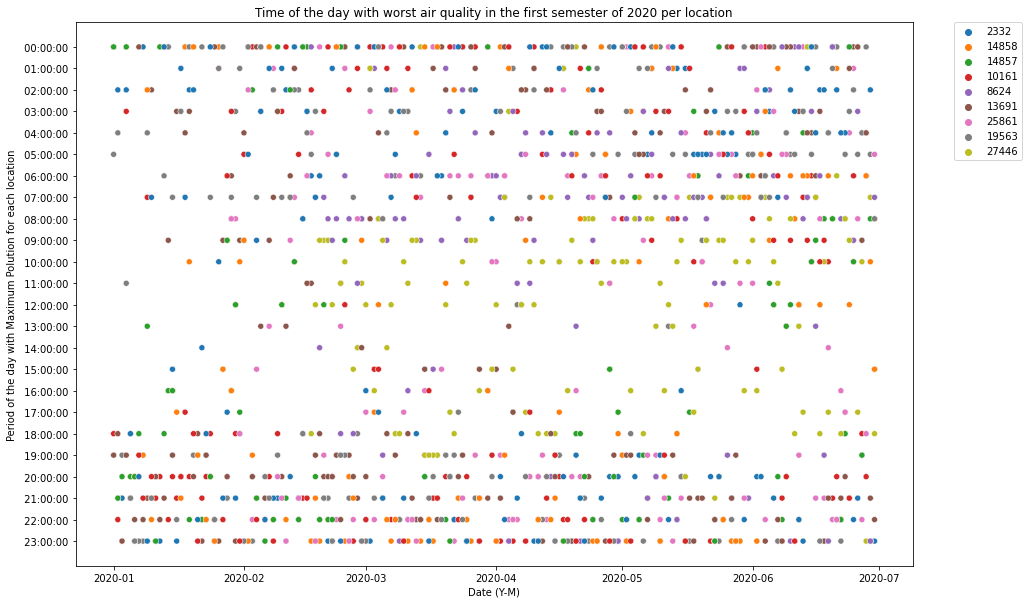

+------------------+--------+-------------------+------------------------------------------+
|max_pol           |location|date               |window                                    |
+------------------+--------+-------------------+------------------------------------------+
|337.26788060805376|14858   |2020-01-01 00:00:00|{2020-01-01 00:00:00, 2020-01-01 01:00:00}|
|692.1841659545898 |2332    |2020-01-01 00:00:00|{2020-01-01 00:00:00, 2020-01-01 01:00:00}|
|77.19354192415874 |13691   |2020-01-01 00:00:00|{2020-01-01 19:00:00, 2020-01-01 20:00:00}|
|168.962495803833  |19563   |2020-01-01 00:00:00|{2020-01-01 05:00:00, 2020-01-01 06:00:00}|
|214.29876587811637|14857   |2020-01-01 00:00:00|{2020-01-01 00:00:00, 2020-01-01 01:00:00}|
|223.38999938964844|10161   |2020-01-01 00:00:00|{2020-01-01 18:00:00, 2020-01-01 19:00:00}|
|430.66567889126867|2332    |2020-01-02 00:00:00|{2020-01-02 02:00:00, 2020-01-02 03:00:00}|
|112.78666671117146|10161   |2020-01-02 00:00:00|{2020-01-02 22:00:00,

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 581, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", line 196, in call
    raise e
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", line 193, in call
    self.func(DataFrame(jdf, self.sql_ctx), batch_id)
  File "<ipython-input-5-29f8fe053e13>", line 40, in dumpBatchDF
    df_p = df_for_plot.toPandas()
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/conversion.py", line 157, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py", line 693, in collect
    sock_info = self._jdf.collectToPython()
  File "/usr/local/lib/python3.7/dist-packages/py

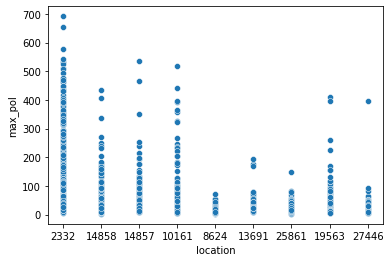

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Comment 1) Initiating Spark session and connecting to Kafka servers
spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')

#Comment 2) Create a schema for the data, naming each column and specifying its data type
schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

#Comment 3) Select the appropriate columns; create new column: sum_pol
df = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')
df1 = df.withColumn('sum_pol',col('p1')+col('p2')/2)\
        .withColumn('date',to_timestamp(substring('timestamp',0,10)))\
        .select('timestamp','location','sum_pol','date')

#Comment 4) Define Watermark (to handle data that arrives late); Group data per location
query = df1.withWatermark('timestamp','2 minutes')\
           .groupBy(window(df1.timestamp,'1 hour','1 hour'),'location')\
           .agg(avg('sum_pol').alias('avg_pol'),min('date').alias('date'))

#Comment 5) Output auxiliary function
def dumpBatchDF(df,epoch_id):
  df_c = df.groupBy('window','location')\
           .agg(max('avg_pol').alias('max_pol'),min('date').alias('date'))\
           .orderBy(desc('window'))

  df_show = df_c.groupBy('date','location')\
                .agg(max(struct('max_pol','window')).alias('max'))\
                .select('max.max_pol','location','date','max.window').orderBy('date')

  #Comment 6) Get the window.start value in order to plot a visual interpertation
  df_for_plot = df_show.withColumn('hour', substring(col('window.start'),11,13))\
                   .orderBy('hour')

  #Comment 7a) Create plot 1 (create PandasDF for that purpose)
  df_p = df_for_plot.toPandas()
  fig, ax = plt.subplots(figsize=(15, 10))
  sns.scatterplot(data=df_p, x='date', y='hour',hue='location')
  plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0)
  plt.title('Time of the day with worst air quality in the first semester of 2020 per location')
  plt.xlabel('Date (Y-M)')
  plt.ylabel('Period of the day with Maximum Polution for each location')
  plt.show()

  #Comment 7b) Create plot 2
  sns.scatterplot(data=df_p, x='location', y='max_pol')
  df_show.show(100,False)

#Comment 8) Create plotDefine output mode: update; call output auxiliary function 
query = query \
    .writeStream \
    .outputMode('complete') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(180)
query.stop()
spark.stop()

## **Unstructured Spark Streaming**
In order to compare results and aspects related to the implementation of different technologies, we implemented Unstructured Spark Streaming to solve this same question.

**Implementation**

After the configuration of a Spark Session (Comment 1), a streaming context was creating for aggregations in data every 24 seconds (corresponding to total of 24 hours in the stream) and connected to 
a socket streaming the data  (Comment 2).

A 'window' with the duration of 48 seconds, sliding every 24 seconds to produce results, was defined, and empty lines were excluded (Comment 3).
Each lines of the input RDD was separated by spaces between words and the location, date (substring of timestamp including Y-M-D and hour) and the value of the sum of P1 and P2 were selected (Comment 4). The key corresponded to
the location and date, so that a reduceByKey() would aggregate all results from the same hour and same location (Comment 5).

A counter was set so that the number of entrances for each key was counted in order to delete repeated results on windows containing less results for the same key (Comment 6, 7 and 8). 
The values with the maximum polution for each polution and day where selected (Comment 9).

**Results and discussion**

Some difficulties we found related to implementation included the limitation related to the fact that we need to aggregate values without a thin control over the values we want to aggregate. While in Structured Spark Streaming we define the batches by the interval of the timestamps, in Unstructured Spark Streaming we have to define them based on the time they are received by the computation. For this reason, it is more difficult to have control over the data, for example, selecting all data uniquely generated in one day.  

On the other hand, it is possible to had a window, which helps us deal with results that are late. We can use a window which slides every 24 seconds (corresponding to 1h), with a 48 second lenght. Nevertheless, after trying this solution, we realized this would mean some values would be repeated. 

Although we defined a window of 48 seconds (corresponding to 48  hours in scource) to collect delayed data, we can notice that, although the time interval corresponding to the time of the day with the poorest air quality is the same for most cases as the one obtained with the implementation of Structured Spark Streaming, the absolute value of polution varies as some delayed results are not counted still. 

For the problem of repeated results over the same key in different windows, we implemented a method which gave us the key-value pair in the interval with the highest number of results for that pair. Nevetheless, we recognize the limitations of this procedure. 

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

#Comment 1) Configuration
spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

try:
  #Comment 2) Define context, agregate data every 24 seconds (corresponding to 24h in the source); Connect to a stream source
  ssc = StreamingContext(spark.sparkContext,24)
  lines = ssc.socketTextStream('localhost', 7777) 

  #Comment 3) Define batches: window lenght of 24 seconds, sliding every 24 seconds; filter empty lines
  result = lines.window(48, 24)\
                .filter(lambda line : len(line)>0)

  #Comment 4) Split lines and select only the usefull parts: select location (part[2]), timestamp ([7]) (only day and hour), the sum of the particles (P1 + P2) ([5] and [6]) and the integer 1
  part = result.map(lambda line: line.split(" "))\
               .map(lambda part: ((part[2],part[7][:13]), (float(part[5])+ float(part[6]),1))) #select location, P1 + P2
  
  #Comment 5) ReduceByKey, with the key being the location and the time; calculate the mean of polution for the location and time (day and hour)
  part1 = part.reduceByKey(lambda a,b:(a[0]+b[0],a[1]+b[1]))\
              .map(lambda x: (x[0][1][:10], (x[0][0], x[0][1][11:]+':00-'+str(int(x[0][1][11:])+1)+':00', x[1][0]/x[1][1])))

  #Comment 6) Count the number of entrances for each key in order to delete the delayed ones. (note we just want a day for window)
  counter = part1.map(lambda x: (x[0],1))\
                 .reduceByKey(lambda x,y: (x+y))

  #Comment 7) Create a map with same key for every lines, and get the maximum of counter column
  maxim = counter.map(lambda x: ('local',x[1]))\
                 .reduceByKey(lambda a,b: max(a,b))

  #Comment 8) Join the original map with counter, then join with maxim (contain the value of the window main day) in order to filter just the lines where counter == maxim
  joint = part1.join(counter)\
               .map(lambda x:('local',x))\
               .join(maxim).filter(lambda z: z[1][0][1][1] == z[1][1])\
               .map(lambda x: (x[1][0][0],x[1][0][1][0][0],x[1][0][1][0][1],x[1][0][1][0][2]))

  #Comment 9) Filter maximum per location and day
  max_loc = joint.map(lambda x: ((x[0],x[1]),float(x[3])))\
                 .reduceByKey(lambda x,y: max(x,y))
  
  #Comment 10) Join the filtered map (join that contains only the valid entrances for each window) with the max_loc in order to filter just the line where polution is max
  joint_final = joint.map(lambda x: ((x[0],x[1]),(x[2],x[3])))\
                     .join(max_loc).filter(lambda x: x[1][0][1]==x[1][1])\
                     .map(lambda x: (x[0][0],x[0][1],x[1][0][0], round(x[1][0][1], 1)))

  joint_final.pprint()
  ssc.start()
  #Comment 11) Define termination time
  ssc.awaitTermination(180)  

except Exception as err:
  print(err)
ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-04-28 20:39:12
-------------------------------------------
('2020-01-01', '14857', '00:00-1:00', 260.2)
('2020-01-01', '10161', '18:00-19:00', 272.2)
('2020-01-01', '19563', '05:00-6:00', 187.5)
('2020-01-01', '13691', '19:00-20:00', 100.9)
('2020-01-01', '14858', '00:00-1:00', 419.9)
('2020-01-01', '2332', '00:00-1:00', 835.3)

-------------------------------------------
Time: 2022-04-28 20:39:36
-------------------------------------------
('2020-01-01', '14857', '00:00-1:00', 260.2)
('2020-01-01', '10161', '18:00-19:00', 272.2)
('2020-01-01', '19563', '05:00-6:00', 187.5)
('2020-01-01', '13691', '19:00-20:00', 100.9)
('2020-01-01', '14858', '00:00-1:00', 419.9)
('2020-01-01', '2332', '00:00-1:00', 835.3)

-------------------------------------------
Time: 2022-04-28 20:40:00
-------------------------------------------
('2020-01-02', '14858', '21:00-22:00', 296.5)
('2020-01-02', '2332', '02:00-3:00', 518.6)
('2020-01-02', '13691', 

# **2. Find the average air quality, for each location. Updated hourly.**


## **Structured Spark Streaming**

**Implementation** 

In the following exercise, SparkDF was used in order to calculate the average air quality for each location and updated for each hour. 

Steps corresponding to Comment 1 through Comment 4 are the same as in the implementation for question 1.

Again, an ouput auxiliary function was defined (Comment 5). The data was grouped based on the window and location so that the mean value for the sum of P1 and P2 was calculated for each location, updated hourly. 
The results were ordered by date. Again, the complete output mode was selected 

No plot was displayed as this query produces a lot of results which make it difficult to visualize any pattern. 


**Results and Discussion**

The results obtained were displayed in a dataframe, where, for each location, one can see the result of the mean of polution updated hourly.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
from pyspark.pandas.spark import functions 
import pyspark.pandas as ps

#Comment 1) Initiating Spark session and connecting to Kafka servers
spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')

#Comment 2) Create a schema for the data, naming each column
schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

#Comment 3)  Select the columns
lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*') \
             .withColumn('sum_pol',col('p1')+col('p2')) \
             .withColumn('date', to_timestamp(substring('timestamp',0,13))) \
             .select('timestamp','location','sum_pol', 'date') 

#Comment 4)  Define Watermark (to handle data that arrives late); Construct the query in order to make transformations to the data
query = lines.withWatermark('timestamp','1 day') \
             .groupBy(window(lines.timestamp,'1 hour','1 hour'),'location') \
             .agg(avg('sum_pol').alias('avg_pol'), min('date').alias('date'))

#Comment 5) Ouput auxiliary function
def dumpBatchDF(df,epoch_id):
  df_c = df.groupBy('window','location').agg(avg('avg_pol').alias('avg_pol'), min('date').alias('date'))\
                                        .orderBy(desc('window'))
  df_show = df_c.groupBy('location', 'date').agg(avg('avg_pol').alias('average_polution'))\
                .drop('window')\
                .orderBy('date')
  df_show.show(100, False)

#Comment 6) Output mode: update; call output auxiliary function
query = query \
    .writeStream \
    .outputMode('complete') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(120)
query.stop()
spark.stop()

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 581, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", line 196, in call
    raise e
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", line 193, in call
    self.func(DataFrame(jdf, self.sql_ctx), batch_id)
  File "<ipython-input-2-b39bcb4bd907>", line 33, in dumpBatchDF
    df_show.show(100, False)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py", line 502, in show
    print(self._jdf.showString(n, int_truncate, vertical))
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1322, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py

##**Unstructured Spark Streaming**

**Implementation**

In the following exercise, we used Unstructured Spark Streaming. 

Implementation from Comment 1 through Comment 4 is similar as the one for exercise 1, whith the difference that in this case we selected windows with 5 seconds of lenght, sliding every second. 

We use a ReduceByKey (Comment 5), with the key being the location and the time, to calculate the mean of polution for the location and time.

**Results and Discussion**

Again, this showed to be a method with serious limitations in terms of implementation, as already mentioned in question 1. For this reason, in the following exercises we used only Structured Spark Streaming, either Spark DF or Spark SQL.


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

#Comment 1) Configuration
spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

try:
  #Comment 2) Define context, agregate data every 1 second; Connect to a stream source
  ssc = StreamingContext(spark.sparkContext, 1) 
  lines = ssc.socketTextStream('localhost', 7777) 
  
  #Comment 3) Define batches: window lenght of 5 seconds, sliding every second; filter empty lines
  result = lines.window(2, 1).filter(lambda line : len(line)>0)
  
  #Comment 4) Split lines and select only the usefull parts: select location, timestamp (only day and hour) and the sum of the particles (P1 + P2)
  part = result.map(lambda line: line.split(" "))\
               .map(lambda part: ( (part[2], part[7][:13]) , (float(part[5])+ float(part[6]), 1) )) 
  
  #Comment 5) ReduceByKey, with the key being the location and the time; calculate the mean of polution for the location and time (day and hour)
  per_loc = part.reduceByKey(lambda l1, l2: (l1[0]+l2[0], l1[1]+l2[1]))\
                .map(lambda line: (line[0][1],(line[0][0],round(float(line[1][0]) / float(line[1][1]), 1))))
  # counter number of entrances for eac key date-hour
  counter=part.map(lambda x: (x[0][1],1)).reduceByKey(lambda a,b: (a+b))

  # prep is a map where we join original and counter
  prep=per_loc.join(counter).map(lambda x: ('local',(x[0],x[1][0][0],x[1][0][1],x[1][1])))

  # get the maximum number of appearances
  maxim=counter.map(lambda x: ('local',x[1])).reduceByKey(lambda a,b:max(a,b))

  # join prep with maxim in order to filter just the key that had the maximum number of appearences in the window
  final=prep.join(maxim).filter(lambda x: x[1][1]==x[1][0][3]).map(lambda x: (x[1][0][0],x[1][0][1],x[1][0][2]))

  
  final.pprint() 
  ssc.start()
  #Define termination time
  ssc.awaitTermination(40)  


except Exception as err:
  print(err)
ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-04-27 11:28:14
-------------------------------------------
('2020-01-01T00', '13691', 59.3)
('2020-01-01T00', '14858', 466.0)
('2020-01-01T00', '10161', 196.4)
('2020-01-01T00', '14857', 307.6)

-------------------------------------------
Time: 2022-04-27 11:28:15
-------------------------------------------
('2020-01-01T00', '13691', 49.1)
('2020-01-01T00', '14858', 419.9)
('2020-01-01T00', '2332', 835.3)
('2020-01-01T00', '10161', 192.4)
('2020-01-01T00', '14857', 260.2)

-------------------------------------------
Time: 2022-04-27 11:28:16
-------------------------------------------
('2020-01-01T01', '14857', 159.5)
('2020-01-01T01', '10161', 162.8)
('2020-01-01T01', '14858', 320.8)
('2020-01-01T01', '2332', 639.5)
('2020-01-01T01', '13691', 41.1)

-------------------------------------------
Time: 2022-04-27 11:28:17
-------------------------------------------
('2020-01-01T02', '2332', 469.2)
('2020-01-01T02', '13691', 36.0)
('20

# **3.Can you show any daily and/or weekly patterns to air quality?**

We began by analyzing daily patterns with one-hour intervals, and then moved on to weekly patterns with one-day intervals.

For both exercises, Spark Streaming Structured was used: for the first of this quesries, we also experimented using Spark Streaming SQL and evaluated both methods. 

##**Are there any daily patterns?**

**Implementation**

Steps corresponding to Comment 1 through Comment 4 are the similar as in the implementation for the previous questions. The timestamp was defined to 1 day (Comment 4). The average polution for each hour, independently of location and the day, was calculated (Comment 5) and the results were sorted by hour. 

A plot was created showing the variation of the average polution at each hour of the day (Comment 6). The ouput mode selected was complete (Comment 7), as we wanted to aggregate all the values already streamed. 

**Results and discussion**

As we can see in the plot, there seems to be a daily pattern consisting of a minimum polution at 2pm, where the average sum of P1 and P2 is 19.48. Then, there is an increasing ammount of pollution until midnight, where pollution achieves its maximum, for a value of 51.24. After that, pollution seems to decrease almost linearly until 2pm. We can observe a significant difference of the mean of the sum of P1 and P2 from the hightest to the lowest daily value of 31.76.

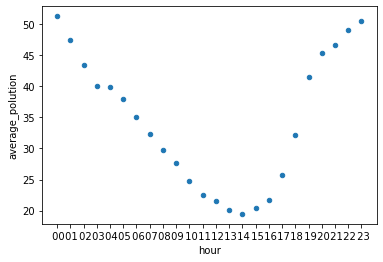

+----+------------------+
|hour|average_polution  |
+----+------------------+
| 00 |51.24279269190176 |
| 01 |47.48006210552272 |
| 02 |43.43247261007029 |
| 03 |40.08177070216189 |
| 04 |39.80524843865487 |
| 05 |37.891720018856645|
| 06 |35.026366250585106|
| 07 |32.3887265323244  |
| 08 |29.77843148159005 |
| 09 |27.693266517535317|
| 10 |24.812217786821584|
| 11 |22.459986237283918|
| 12 |21.4972911219073  |
| 13 |20.087237858739613|
| 14 |19.47608026887892 |
| 15 |20.506749115656447|
| 16 |21.675035921252743|
| 17 |25.808139132847383|
| 18 |32.17785542721738 |
| 19 |41.4512050147825  |
| 20 |45.35006009773297 |
| 21 |46.667018795963   |
| 22 |48.98477221204227 |
| 23 |50.515711587768145|
+----+------------------+



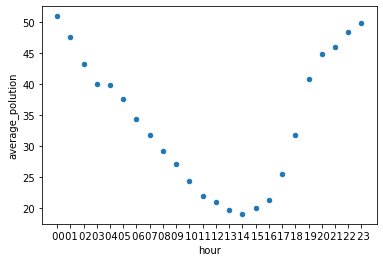

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 581, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", line 196, in call
    raise e
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", line 193, in call
    self.func(DataFrame(jdf, self.sql_ctx), batch_id)
  File "<ipython-input-22-9d576f1bd2d9>", line 35, in dumpBatchDF
    df.show(24, False)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py", line 502, in show
    print(self._jdf.showString(n, int_truncate, vertical))
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1322, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", li

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
from pyspark.pandas.spark import functions 
import pyspark.pandas as ps

#Comment 1) Initiating Spark session and connecting to Kafka servers
spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')

#Comment 2) Create a schema for the data, naming each column
schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

#Comment 3) Select the columns
lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*') \
             .withColumn('sum_pol',col('p1')+col('p2'))\
             .withColumn('hour', substring('timestamp',11,3))\
             .select('timestamp', 'sum_pol', 'hour') 

#Comment 4) Define Watermarking; Construct the query in order to make transformations to the data
query = lines.withWatermark('timestamp','1 hour') \
             .groupBy(window(lines.timestamp, '1 hour','1 hour'),'hour') \
             .agg(avg('sum_pol').alias('avg_pol'))\
             .select('hour', 'avg_pol')

#Comment 5) Output auxiliary function
def dumpBatchDF(df,epoch_id):
  df = df.groupBy('hour').agg(avg('avg_pol').alias('average_polution'))
  df = df.sort('hour')

  #Comment 6) Create plot
  df_plot = df.toPandas()
  fig, ax = plt.subplots(figsize=(15, 10))
  df_plot.plot(x ='hour', y='average_polution', kind = 'scatter')
  plt.show()
  
  df.show(24, False)


#Comment 7) Output mode: update; call output auxiliary function
query = query \
    .writeStream \
    .outputMode('complete') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(120)
query.stop()
spark.stop()

###**SPARK SQL**


**Implementation**

We decided to implement Structured Spark Streaming using an SQL query in order to evaluate its implementation comparing to other metdos.

In this case, the implementation is very similar to Spark Streaming DF except for the step corresponding to the SQL query (Comment 4). This query consists of calculating average polution for each hour, independently of location and the day,(Comment 5) and order the results by hour. 

A plot was created showing the variation of the average polution at each hour of the day (Comment 6). 

We realized that, uusing the Spark Streaming SQL, it is not possible to implement queries that use aggregations in different steps.

**Results and discussion**

As we can see in the plot, there seems to be a daily pattern very similar to that obtained in Spark Streaming SQL. Nevertheless, there are differences in the absolute values obtained, that may be explained by the fact that we are not using Watermark in this query.

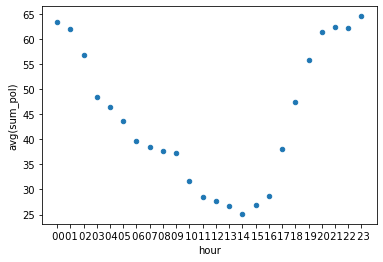

+----+------------------+
|hour|avg(sum_pol)      |
+----+------------------+
| 00 |63.32118496404696 |
| 01 |61.931826284504   |
| 02 |56.75709452493092 |
| 03 |48.38959451076826 |
| 04 |46.34104604905644 |
| 05 |43.65470146926796 |
| 06 |39.61470833709634 |
| 07 |38.41777684232892 |
| 08 |37.649637545824085|
| 09 |37.330150717444674|
| 10 |31.684579461675824|
| 11 |28.48997418521154 |
| 12 |27.7990906639792  |
| 13 |26.64471301345748 |
| 14 |25.13223668312629 |
| 15 |26.947966621109654|
| 16 |28.70192022431796 |
| 17 |38.05306332145694 |
| 18 |47.52346573934864 |
| 19 |55.72917697154664 |
| 20 |61.43578573798807 |
| 21 |62.350699707183516|
| 22 |62.110765977771486|
| 23 |64.52809396641912 |
+----+------------------+



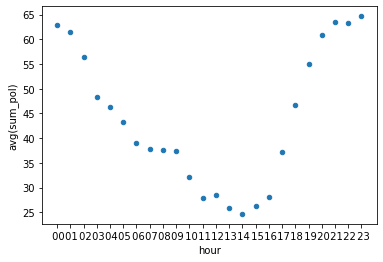

+----+------------------+
|hour|avg(sum_pol)      |
+----+------------------+
| 00 |62.96601024741101 |
| 01 |61.45184300949535 |
| 02 |56.42140643153995 |
| 03 |48.37891508216702 |
| 04 |46.232657121499344|
| 05 |43.335833527756606|
| 06 |38.950167040290324|
| 07 |37.744051896968095|
| 08 |37.56833996339249 |
| 09 |37.467288444061076|
| 10 |32.11177750282719 |
| 11 |27.996906350121478|
| 12 |28.578541293793826|
| 13 |25.93833875786981 |
| 14 |24.679303615259265|
| 15 |26.249501353270507|
| 16 |28.129035372882036|
| 17 |37.117482931609445|
| 18 |46.73277656725379 |
| 19 |54.93036293706379 |
| 20 |60.963842992617764|
| 21 |63.39672477961625 |
| 22 |63.372505186866576|
| 23 |64.66104237176643 |
+----+------------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
from pyspark.pandas.spark import functions 
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns

#Comment 1) Initiating Spark session and connecting to Kafka servers
spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')

#Comment 2) Create a schema for the data, naming each column
schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

#Comment 3) Select the columns
lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*') \
             .withColumn('sum_pol',col('p1')+col('p2'))\
             .withColumn('hour', substring('timestamp',11,3))\
             .select('sum_pol', 'hour') 


#Comment 4) Create TempView for SQL; Create SQL query
lines.createOrReplaceTempView('df_SQL')
query = spark.sql("SELECT hour, AVG(sum_pol) FROM df_SQL GROUP BY hour ORDER BY hour")

#Comment 5) Output auxiliary function
def dumpBatchDF(df,epoch_id):
  
  #Comment 6) Create plot
  df_plot = df.toPandas()
  df_plot.plot(x ='hour', y='avg(sum_pol)', kind = 'scatter')
  plt.show()

  df.show(128, False)


#Comment 6) Output mode: update; call output auxiliary function
query = query \
    .writeStream \
    .outputMode('complete') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(120)
query.stop()
spark.stop()

##**Are there any weakly patterns?**


**Implementation**

Steps corresponding to Comment 1 through Comment 4 are the similar as in the implementation for the previous questions. The timestamp was defined to 1 day (Comment 4). An ouput auxiliary function was created (Comment 5) in order to create a column corresponding to the weekday of the data and aggregate the values of average pollution for each day of the week. To order the results, a correspondance of each day of the week to the number of order was computed (Comment 6).

A plot was created showing the variation of the average polution for each day of the week (Comment 7). 

**Results and Discussion**

As we can see on the plot, the day of the week with the highest pollution is Thursday, with a sum of P1 and P2 of 33.12. From thursday until Tuesday, the value for polution has an almost linear tendency to decrease, achieving its minimum of 26.94, and abruptaly increases on Wednesday. As we can see, although there is some differences between the days of the week, this is not very marked (only 6.18 in the sum of both P1 and P2). When considering the daily variability (31.76), we see that this is a small variation. 

For this reason, we consider that it does not seem to exist a weekly pattern with significant variations, although this should be proved statistically. 

+--------+------------------+---------+
|week_day|avg_pol           |week_code|
+--------+------------------+---------+
|Mon     |27.517329835291566|0        |
|Tue     |26.943959982916436|1        |
|Wed     |32.319818103784236|2        |
|Thu     |33.121016768522686|3        |
|Fri     |32.157858665014146|4        |
|Sat     |30.710823725375047|5        |
|Sun     |28.886545550108828|6        |
+--------+------------------+---------+



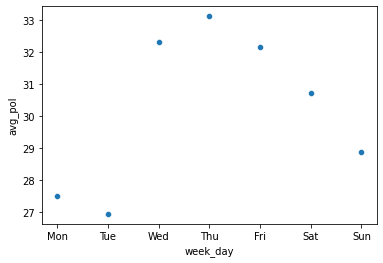

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Comment 1) Initiating Spark session and connecting to Kafka servers
spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')

#Comment 2) Create a schema for the data, naming each column
schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

#Comment 3) Select the columns
lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*') \
             .withColumn('sum_pol', col('P1')+col('P2')) \
             .withColumn('date', to_timestamp(substring('timestamp',0,10))) \
             .select('timestamp', 'sum_pol', 'date') 

#Comment 4) Construct the query in order to make transformations to the data
query = lines.withWatermark('timestamp','1 hour')\
             .groupBy('date')\
             .agg(avg('sum_pol').alias('avg_pol'))


#Comment 5) Output auxiliary function
def dumpBatchDF(df,epoch_id):
  df = df.orderBy('date')
  df = df.withColumn('week_day',date_format('date', 'E'))
  df = df.drop('date').groupBy('week_day').agg(avg('avg_pol').alias('avg_pol'))
  
  #Comment 6)Create Column with code for day of the week in order to sort
  df = df.withColumn("week_code", (when(col("week_day") == 'Mon', 0)\
                                  .when(col("week_day") == 'Tue', 1)\
                                  .when(col("week_day") == 'Wed', 2)\
                                  .when(col("week_day") == 'Thu', 3)\
                                  .when(col("week_day") == 'Fri', 4)\
                                  .when(col("week_day") == 'Sat', 5)\
                                  .otherwise(6)))
  df = df.sort('week_code')

  #Comment 7) Create plot
  df_p = df.toPandas()
  sns.scatterplot(data=df_p, x='week_day', y='avg_pol')
  df.show(100, False)
  
#Comment 8) Define output mode
query = query \
    .writeStream \
    .outputMode('complete') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(90)
query.stop()
spark.stop()

# **4. The data covers a period of extensive population confinement due to Covid 19. Can you find a signal in the data showing air quality improvement coinciding with the confinement period?**

**Implementation**

For this question, we want to evaluate the influence of the Covid 19 pandemic in the air quality. To solve this problem, we use Structured Spark Streaming using Dataframes. 

Steps corresponding to Comment 1 and 2 are similar to the ones previously implemented. For this question, the values of P1 and P2 were selected, instead of their sum, in order to plot them separatly (Comment 3). 

Watermarking was set to '1 day' (Comment 4). For each day, the mean of P1 and the mean of P2 was calculated (Comment 5).

A plot was created showing the results of mean P1 and P2 for each day of the first semester of 2020 (Comment 6).

The 'update' ouput mode was selected as there are no aggregations between values on different batches, and we want to create a dataframe with the values for all the days in the first semester of 2020 to create a plot (Comment 7). 

**Results and discussion**

As we can observe in the plot shown bellow, both the values of P1 and P2 seem to decrease over time, specially in the middle of march, staying stable from that point on. 

As we can observe in the Council of Ministers Official Communication, an emergency state was decreted on the 18th of march 2020 in Portugal. From this day, an extensive population confinement was introduced. 

This coincides with the decrease of pollution in our dataset, so we have reasons to believe the confinement due to Covid-19 may have influenced the air quaility in Lisbon. To draw more conclusions we believe it is needed to perform statistical evaluations of this data. 

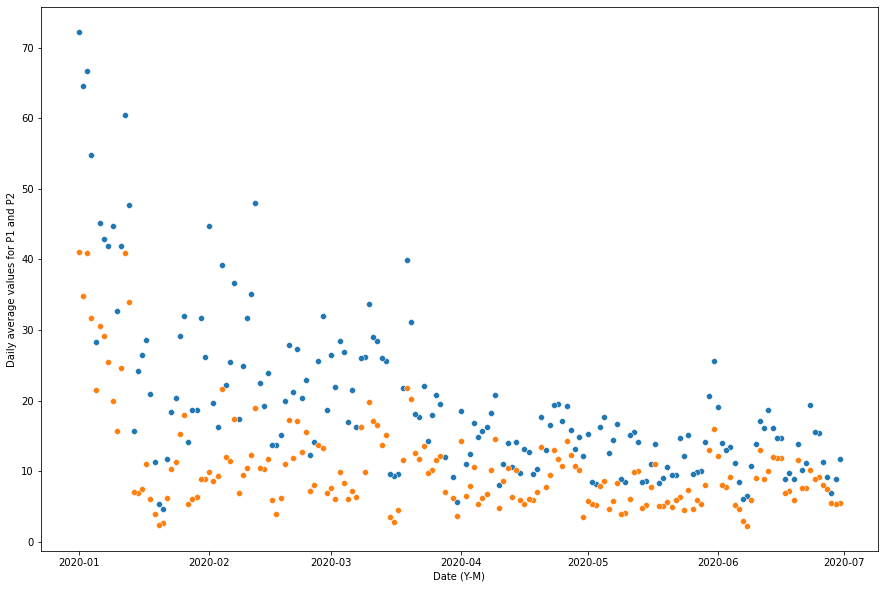

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

#Comment 1) Initiating Spark session and connecting to Kafka servers
spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')

# Comment 2) Define schema
schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

#Comment 3) Select relevant columns
df = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')
df1 = df.withColumn('date',to_timestamp(substring('timestamp',0,11)))\
        .select('timestamp','p1','p2','date')

#Comment 4) Define Watermarking: groupBy
query = df1.withWatermark('timestamp','1 hour')\
           .groupBy('timestamp').agg(avg('p1').alias('avg_p1'),avg('p2').alias('avg_p2'),min('date').alias('date'))

#Comment 5) Define auxiliary output function
def dumpBatchDF(df,epoch_id):
  df_c=df.groupBy('date').agg(avg('avg_p1').alias('avg_p1'),avg('avg_p2').alias('avg_p2'))\
         .drop('timestamp')\
         .orderBy(desc('date'))

  #Comment 6) Plot the data
  if df_c.count() > 1:
    df_p = df_c.toPandas()
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.scatterplot(data=df_p, x='date', y='avg_p1')
    sns.scatterplot(data=df_p, x='date', y='avg_p2', legend = "brief")
    plt.xlabel('Date (Y-M)')
    plt.ylabel('Daily average values for P1 and P2')
    df_c.show(100,False)

#Comment 7) Define ouput mode: append 
query = query \
    .writeStream \
    .outputMode('append') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(120)
query.stop()
spark.stop()